In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
import matplotlib.pyplot as plt
import tifffile
import numpy as np
from sklearn.model_selection import train_test_split

c:\Users\rz200\Anaconda3\envs\unetenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
def randomCrop(img, mask, width, height):
    assert img.shape[0] >= height
    assert img.shape[1] >= width
    assert img.shape[0] == mask.shape[0]
    assert img.shape[1] == mask.shape[1]
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width]
    mask = mask[y:y+height, x:x+width]
    return img, mask

In [4]:
def padding(array, xx, yy):
        h = array.shape[0]
        w = array.shape[1]
        a = (xx - h) // 2
        aa = xx - a - h
        b = (yy - w) // 2
        bb = yy - b - w
        return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [99]:
def get_data(img_path,mask_path,img_ids,upper_lim=0):
    full_original_imgs = []
    full_original_masks = []
    for i in img_ids:
        print(str(i) + '/' + str(len(img_ids)))
        file_path = img_path + '\\' + str(i) + '.tif'
        image = tifffile.imread(file_path)
        image = np.squeeze(image)
        full_original_imgs.append(image)

        file_path = mask_path + '\\' + str(i) + '.tif'
        mask = tifffile.imread(file_path)
        mask = np.squeeze(mask)
        full_original_masks.append(mask)

    initial_data = []
    for i in range(len(full_original_imgs)):
        print(str(i) + '/' + str(len(full_original_imgs)))
        img = full_original_imgs[i]
        images = [img[:, :, 0],img[:, :, 1],img[:, :, 2],img[:, :, 3]]   
        initial_data.append((full_original_masks[i],images))

    cropped_imgs = []
    cropped_masks = []
    
    j = 0
    for data in initial_data:
        print(str(j) + '/' + str(len(initial_data)))
        j += 1
        mask = data[0]
        images = data[1]
        for img in images:
            for i in range(500):
                crop_width = random.randint(5,250)
                crop_height = random.randint(5,250)
                crop_img, crop_mask = randomCrop(img, mask, crop_width, crop_height)
                
                #pad the images to (250,250)
                crop_img = padding(crop_img,250,250)
                crop_mask = padding(crop_mask,250,250)

                #expand the dims
                crop_img = np.expand_dims(crop_img,-1)
                crop_mask = np.expand_dims(crop_mask,-1)

                #move the axis
                crop_img = np.moveaxis(crop_img, -1, 0)
                crop_mask = np.moveaxis(crop_mask,-1,0)

                #to torch
                crop_img = torch.from_numpy(crop_img.astype(np.float))
                crop_mask = torch.from_numpy(crop_mask.astype(np.float))

                cropped_imgs.append(crop_img)
                cropped_masks.append(crop_mask)

    if upper_lim != 0:
        return cropped_imgs[:upper_lim], cropped_masks[:upper_lim]

    return cropped_imgs, cropped_masks

In [98]:
def get_train_test_data(img_path, mask_path, img_ids, test_size=0.3, upper_lim=0):
    img_data, mask_data = get_data(img_path, mask_path, img_ids, upper_lim)
    X_train, X_test, y_train, y_test = train_test_split(img_data, mask_data, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [162]:
img_path = os.getcwd() + '\812_plate'
mask_path = os.getcwd() + '\812_plate_masks'
img_ids = [1,2,3,4,5,6]
img_data, mask_data = get_data(img_path, mask_path, img_ids, 10000)

print('Num imgs:',len(img_data))
print('Num masks:',len(mask_data))

1/6
2/6
3/6
4/6
5/6
6/6
0/6
1/6
2/6
3/6
4/6
5/6
0/6


C:\Users\rz200\AppData\Local\Temp\ipykernel_39456\1247727049.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_img = torch.from_numpy(crop_img.astype(np.float))
C:\Users\rz200\AppData\Local\Temp\ipykernel_39456\1247727049.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_mask = torch.from_numpy(crop_mask.astype(np.float))


1/6
2/6
3/6
4/6
5/6
Num imgs: 10000
Num masks: 10000


In [165]:
X_train, X_test, y_train, y_test = get_train_test_data(img_path, mask_path, img_ids, upper_lim=10000)

1/6
2/6
3/6
4/6
5/6
6/6
0/6
1/6
2/6
3/6
4/6
5/6
0/6


C:\Users\rz200\AppData\Local\Temp\ipykernel_39456\1247727049.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_img = torch.from_numpy(crop_img.astype(np.float))
C:\Users\rz200\AppData\Local\Temp\ipykernel_39456\1247727049.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_mask = torch.from_numpy(crop_mask.astype(np.float))


1/6
2/6
3/6
4/6
5/6


In [166]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))


6700 6700
3300 3300


In [167]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

#transforms = transforms.Compose([transforms.CenterCrop((250,250))])

trainDS = []
for i in range(len(X_train)):
	trainDS.append((X_train[i],y_train[i]))
	#trainDS.append((transforms(X_train[i]),transforms(y_train[i])))

testDS = []
for i in range(len(X_test)):
    testDS.append((X_test[i],y_test[i]))

print(len(trainDS),len(testDS))

trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=5, pin_memory=PIN_MEMORY,
	num_workers=2)

testLoader = DataLoader(testDS, shuffle=True,
	batch_size=5, pin_memory=PIN_MEMORY,
	num_workers=2)



6700 3300


In [168]:
os.cpu_count()

24

In [169]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import ReLU

class Block(Module):
	
	def __init__(self, inChannels, outChannels):
		super().__init__()
		self.conv1 = Conv2d(inChannels, outChannels, 4)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 4)

	def forward(self, x):
		return self.conv2(self.relu(self.conv1(x))) #CONV->RELU->CONV

In [170]:
from torch.nn import ModuleList
from torch.nn import MaxPool2d

class Encoder(Module):

	def __init__(self, channels=(1, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)

	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [171]:
from torch.nn import ConvTranspose2d
from torchvision.transforms import CenterCrop

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2)for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
		
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [172]:
class UNet(Module):
	def __init__(self, encChannels=(1, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=1, retainDim=True, outSize=(250,  250)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [173]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

unet = UNet().to(DEVICE)
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=0.00001)
trainSteps = len(trainDS)
testSteps = len(testDS)

H = {"train_loss": [], "test_loss": []}

In [174]:
print("[INFO] training the network...")
import time
startTime = time.time()
NUM_EPOCHS = 20
for e in range(NUM_EPOCHS):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	#print('going through trainLoader')
	training_loader_iter = iter(trainLoader)
	#print('going throug loop')
	for i in range(len(trainLoader)):
		#print(str(i) + '/' + str(len(trainLoader)))
		# send the input to the device
		x, y = next(iter(training_loader_iter))
		(x, y) = (x.to('cuda'), y.to('cuda'))
		# perform a forward pass and calculate the training loss
		x = x.float()
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	#print('going through no_grad')
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to('cuda'), y.to('cuda'))
			# make the predictions and calculate the validation loss
			x = x.float()
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	#avgTrainLoss = avgTrainLoss.item()
	#avgTrainLoss.detach().to('cpu').numpy()[0]
	H["train_loss"].append(avgTrainLoss.item())
	H["test_loss"].append(avgTestLoss.item())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("       Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/20
       Train loss: -201835627711.614410, Test loss: -2401819940108.9863
[INFO] EPOCH: 2/20
       Train loss: -947402410185508.750000, Test loss: -5281559568010826.0000
[INFO] EPOCH: 3/20
       Train loss: -81897238767899040.000000, Test loss: -294736159223088896.0000
[INFO] EPOCH: 4/20
       Train loss: -1731482253240671232.000000, Test loss: -4478062488611770880.0000
[INFO] EPOCH: 5/20
       Train loss: -14197966145434585088.000000, Test loss: -29308963099496386560.0000
[INFO] EPOCH: 6/20
       Train loss: -64116880302704893952.000000, Test loss: -105514649208783486976.0000
[INFO] EPOCH: 7/20
       Train loss: -181207228732436152320.000000, Test loss: -254124933505845100544.0000
[INFO] EPOCH: 8/20
       Train loss: -362863313664394854400.000000, Test loss: -460636118541563789312.0000
[INFO] EPOCH: 9/20
       Train loss: -627603299332798545920.000000, Test loss: -759381469216078299136.0000
[INFO] EPOCH: 10/20
       Train loss: 

KeyboardInterrupt: 

In [175]:
print(H)

{'train_loss': [-201835627711.6144, -947402410185508.8, -8.189723876789904e+16, -1.7314822532406712e+18, -1.4197966145434585e+19, -6.411688030270489e+19, -1.8120722873243615e+20, -3.6286331366439485e+20, -6.276032993327985e+20, -9.555972001084597e+20, -1.303633770864453e+21, -1.5241695842369898e+21, -1.7108160558523537e+21], 'test_loss': [-2401819940108.9863, -5281559568010826.0, -2.947361592230889e+17, -4.478062488611771e+18, -2.9308963099496387e+19, -1.0551464920878349e+20, -2.541249335058451e+20, -4.606361185415638e+20, -7.593814692160783e+20, -1.105871943522748e+21, -1.3722216658086566e+21, -1.5610636720655153e+21, -1.7436416548639054e+21]}


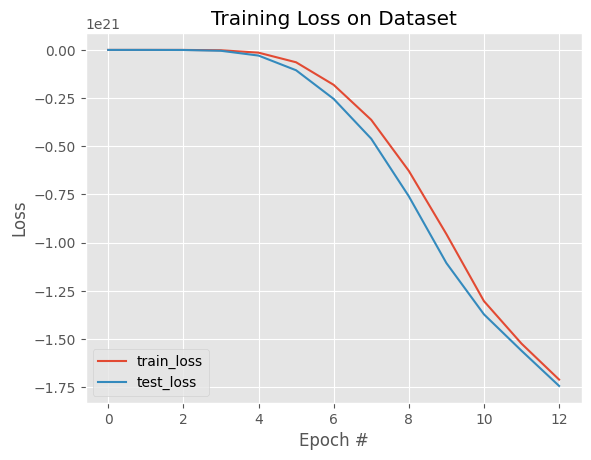

In [176]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()
#plt.savefig(config.PLOT_PATH)
# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [178]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
			config.INPUT_IMAGE_HEIGHT))

In [179]:
print(X_test[0].shape)

torch.Size([1, 250, 250])


In [180]:
img_evaldata, mask_evaldata = get_data(img_path, mask_path, [3,4], 100)
print(len(img_evaldata),len(mask_evaldata))

3/2
4/2
0/2
1/2
0/2


C:\Users\rz200\AppData\Local\Temp\ipykernel_39456\1247727049.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_img = torch.from_numpy(crop_img.astype(np.float))
C:\Users\rz200\AppData\Local\Temp\ipykernel_39456\1247727049.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_mask = torch.from_numpy(crop_mask.astype(np.float))


1/2
100 100


In [182]:
unet.eval()
image = img_evaldata[1]

image_tosave = np.copy(image)

image_input = image.detach().cpu().numpy()


image_input = np.expand_dims(image_input,-1)
image_input = np.moveaxis(image_input,-1,0)

image_input = torch.from_numpy(image_input)
image_input = image_input.to('cuda')
image_input = image_input.float()

print(image_input.shape)
#num_image = image.detach().cpu().numpy()
#num_image = np.moveaxis(num_image,0,-1)
#print(num_image.shape)
#plt.imshow(num_image)
with torch.no_grad():
    predMask = unet(image_input).squeeze()
    

torch.Size([1, 1, 250, 250])


In [183]:
print(image_tosave.shape)
print(mask.shape)

(1, 250, 250)
(250, 250, 1)


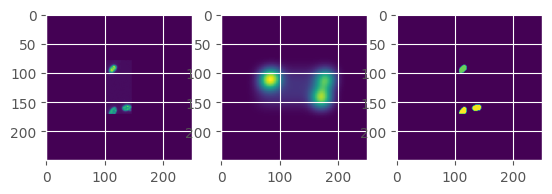

In [184]:
plt.subplot(1,3,1)
#image = image.detach().cpu().numpy()
image_tosave = np.moveaxis(image_tosave,0,-1)
plt.imshow(image_tosave)

plt.subplot(1,3,2)
predMask = predMask.detach().cpu().numpy()
predMask = np.moveaxis(predMask,0,-1)
plt.imshow(predMask)

plt.subplot(1,3,3)
mask = mask_evaldata[1]
mask = mask.detach().cpu().numpy()
mask = np.moveaxis(mask,0,-1)
plt.imshow(mask)

plt.show()

In [ ]:
print(np.unique(predMask))

[2.1099931e+13 2.2144543e+13 2.3114040e+13 ... 3.6028096e+17 3.6095781e+17
 3.6116734e+17]


In [ ]:
print(asfoiasofhahof)

NameError: name 'asfoiasofhahof' is not defined

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

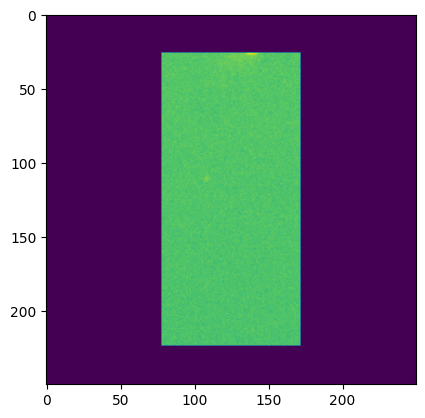

<class 'torch.Tensor'>


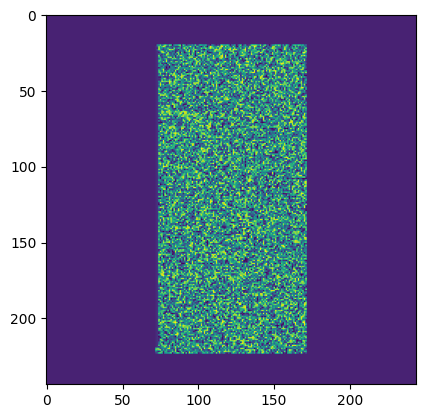

In [ ]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor

transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((250,250)),
	transforms.ToTensor()])

image = X_train[2].astype(int)
plt.imshow(np.squeeze(image))
plt.show()
image = transforms(image)
print(type(image))

b = Block(1,1)
output = b.forward(image.float())
output = ToPILImage()(output)
plt.imshow(output)
plt.show()

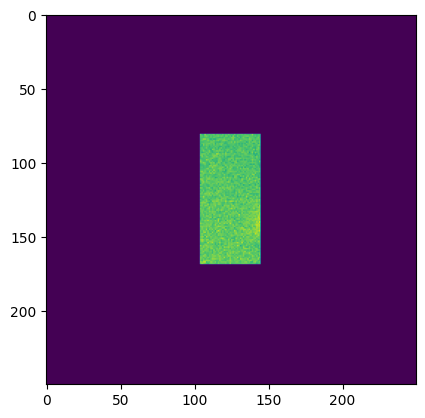

<class 'torch.Tensor'>
torch.Size([1, 1, 250, 250])


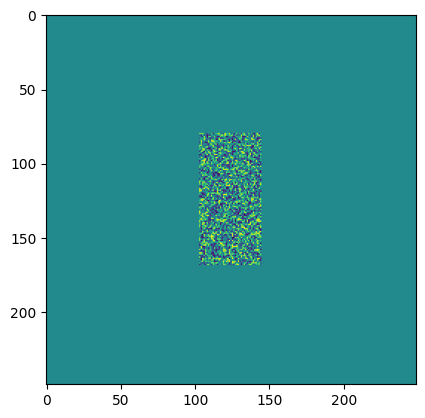

In [ ]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor

transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((250,250)),
	transforms.ToTensor()])

image = X_train[0].astype(int)
plt.imshow(np.squeeze(image))
plt.show()
image = transforms(image)
print(type(image))

conv_ex = Conv2d(1,1,2)
image = image.unsqueeze(0)
print(image.size())
output = conv_ex(image.float())
output = output.squeeze(0)
output = ToPILImage()(output)
plt.imshow(output)

In [ ]:
b = Block(1,1)

img = X_train[0]
img = np.moveaxis(img, -1, 0)
x_data = torch.from_numpy(img)
x_data = x_data.unsqueeze(0)

img = b.forward(x_data)

In [ ]:
plt.imshow(X_train[0])

In [ ]:
#input = torch.empty(2,2,4,4).random_(256)

img = X_train[0]
img = np.moveaxis(img, -1, 0)
x_data = torch.from_numpy(img)
x_data = x_data.unsqueeze(0)
print(x_data.size())

conv_ex = Conv2d(1,3,2)
output = conv_ex(x_data)

plt.imshow(output)

In [ ]:
conv_ex = Conv2d(2,3,2)
x = random.random((25,25,1))
output = conv_ex(x)

In [ ]:
from numpy import random

b = Block(1,1)
x = random.random((25,25,3))
plt.imshow(x)
plt.show()
b.forward(x)